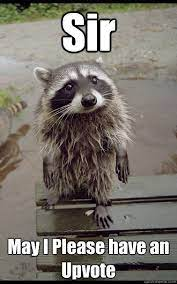

# PLEASE CHECKOUT MY NEW DATASET
- https://www.kaggle.com/keagle/mountains-dataset-with-coordinates-and-countries
- https://www.kaggle.com/keagle/list-of-indian-festivals-for-2022

Based on previous works
# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [1]:
#!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [3]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model

In [4]:
from fastai.vision.all import *

In [5]:
set_seed(999, reproducible=True)
BATCH_SIZE = 32

Let's check what data is available to us:

In [6]:
dataset_path = Path('../input/petfinder-adoption-prediction/')
dataset_path.ls()

(#17) [Path('../input/petfinder-adoption-prediction/test_sentiment'),Path('../input/petfinder-adoption-prediction/ColorLabels.csv'),Path('../input/petfinder-adoption-prediction/train_images'),Path('../input/petfinder-adoption-prediction/breed_labels.csv'),Path('../input/petfinder-adoption-prediction/BreedLabels.csv'),Path('../input/petfinder-adoption-prediction/test_metadata'),Path('../input/petfinder-adoption-prediction/PetFinder-StateLabels.csv'),Path('../input/petfinder-adoption-prediction/train_sentiment'),Path('../input/petfinder-adoption-prediction/StateLabels.csv'),Path('../input/petfinder-adoption-prediction/state_labels.csv')...]

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

In [7]:
train_df = pd.read_csv(dataset_path/'train/train.csv')
train_df.head().T

,0,1,2,3,4
Type,2,2,1,1,1
Name,Nibble,No Name Yet,Brisco,Miko,Hunter
Age,3,1,1,4,1
Breed1,299,265,307,307,307
Breed2,0,0,0,0,0
Gender,1,1,1,2,1
Color1,1,1,2,1,1
Color2,7,2,7,2,0
Color3,0,0,0,0,0
MaturitySize,1,2,2,2,2


In [8]:
(train_df.Breed1.value_counts() > 10).index

Int64Index([307, 266, 265, 299, 264, 292, 285, 141, 205, 179,
            ...
            290, 201,  16, 165, 257, 176, 214, 125, 123,  81],
           dtype='int64', length=176)

The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

Let's do some quick processing of the image filenames to make it easier to access:

In [9]:
train_df['path'] = train_df['PetID'].map(lambda x:str(dataset_path/'train_images'/x)+'-1.jpg')
train_df = train_df[train_df['path'].map(os.path.exists)].reset_index(drop=True)
train_df = train_df[train_df['Breed1'].isin((train_df['Breed1'].value_counts() > 10).index)].reset_index(drop=True)
train_df = train_df.drop(columns=['PetID'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed,path
0,1,Dexter,41,307,0,1,2,3,0,2,...,1,1,0,41326,28863e2bec16331b9bb916ce484e09b7,0,Very cheerful and loves to play and be around people.,5.0,2,../input/petfinder-adoption-prediction/train_images/7803e9e5d-1.jpg
1,2,Lola,5,266,0,2,1,6,0,1,...,1,1,0,41326,e25347680c8fbb85cb974112bd6855d5,0,"Lola is my name and I am the smallest one..but don't be fool by my innocent face..I can be as fierce as a tiger, rarr! We all need a loving home. If can take me together with Bimba or Boss, it will be much better for us..I will make your life happier! Regards, Lola",5.0,2,../input/petfinder-adoption-prediction/train_images/0415fa071-1.jpg
2,1,Garlicc,2,307,0,1,2,7,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,"Garlic is a strong and healthy boy. He is full of energy and wants attention. Garlic was rescued off the streets when two of his siblings were crushed by a lorry. If you have a loving home and lots of love to give, call us at.",4.0,2,../input/petfinder-adoption-prediction/train_images/b2f2134bd-1.jpg
3,2,Vitany,2,241,264,2,5,6,7,2,...,1,1,0,41326,e62135526c27156b8479420aad166317,0,"Introducing foxy little Vitany! ♥ Female kitten, 8 weeks old. Silver / gray-coated with long fur and hazel eyes. ♥ A little diva! She acts classy 24/7 (constantly grooming herself and observing her surroundings). She's soft-mannered even during her most playful moods. A very mature girl! ♥ Quite vocal and will be the first to call out to you when she sees you. :) Vitany isn't too hyper and prefers to chill / lay back more than be in any active situation. ♥ Healthy, has been de-wormed (once), is still too young to be vaccinated. Already clever with the litter-box and able to eat kibbles ind...",6.0,1,../input/petfinder-adoption-prediction/train_images/a76cbec89-1.jpg
4,1,Bobby,3,307,0,1,2,4,0,2,...,1,1,0,41332,c992c6f97bb6cfb719fa9ccb3ef6e53b,0,Bobby is an active and friendly kid. He is a good home pet. ( On 3.7. Bobby is booked by a person.) Will update the status once adopted. Thanks for adopting instead of buying,3.0,4,../input/petfinder-adoption-prediction/train_images/fcf5f5a0d-1.jpg


## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

In [10]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


<AxesSubplot:>

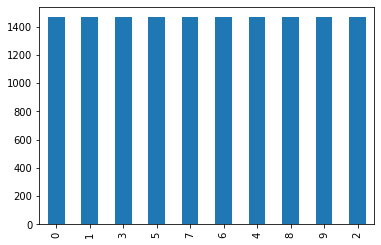

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['Breed1'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [12]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='Breed1', #label is in the first column of the DataFrame
                               y_block=CategoryBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls


In [13]:
#Valid Kfolder size
the_data = get_data(0)
#assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [14]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('efficientnet_b1', pretrained=True, num_classes=data.c)
    print(data.c)

    learn = Learner(data, model, loss_func=CrossEntropyLossFlat(), metrics=CrossEntropyLossFlat()).to_fp16()
    
    return learn

172


SuggestedLRs(valley=0.00024877983378246427)

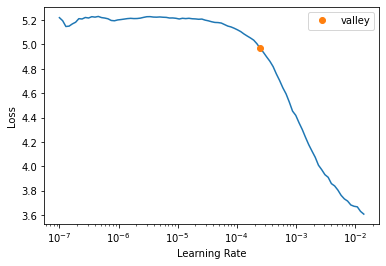

In [15]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [16]:
import gc

In [17]:
all_preds = []

for i in range(N_FOLDS):

    print(f'= {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(fname=f'model_breed_{i}', 
                                                   monitor='valid_loss',
                                                   every_epoch=False,
                                                comp=np.less),
                                      EarlyStoppingCallback(monitor='valid_loss', comp=np.less, patience=2)]) 
    
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

= 0 results
172


epoch,train_loss,valid_loss,None,time


KeyError: Caught KeyError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py", line 256, in encodes
    return TensorCategory(self.vocab.o2i[o])
KeyError: 176

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 118, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.7/site-packages/fastcore/basics.py", line 217, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 133, in do_item
    try: return self.after_item(self.create_item(s))
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/load.py", line 140, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 332, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 332, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 298, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/core.py", line 260, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 200, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 150, in compose_tfms
    x = f(x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 73, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 83, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/transform.py", line 89, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/dispatch.py", line 118, in __call__
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py", line 258, in encodes
    raise KeyError(f"Label '{o}' was not included in the training dataset") from e
KeyError: "Label '176' was not included in the training dataset"
